# Source signature and de-ghosting filter estimation

> “Why worry? Each one of us is carrying an unlicensed nuclear accelerator on his back.” Peter Venkman, Ghostbusters (1984)

Now it's time for some de-ghosting, for that I'll try to follow [this excelent tutorial](http://seismicreflections.globeclaritas.com/2013/05/marine-processing-part-1-resample.html) by Guy Maslen.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import rsf.api as sf

%matplotlib inline

# Set a custom DATAPATH to Madagascar
%env DATAPATH=/home/rodrigo/Projetos/Viking/DATAPATH/

env: DATAPATH=/home/rodrigo/Projetos/Viking/DATAPATH/


In [2]:
sns.set_style('ticks')

In [3]:
# This requires scipy 1.2.0 at least
from scipy.signal import minimum_phase, decimate, correlate

# Processing steps

Processing steps to make a de-ghosting filter:

- Read the wavelet signature
- Correct for possible recording delay times
- Calculate the wavelet spectra
- Identify notches in the spectra
- Estimate source ghosting delay time from source depth
- Deal with receiver ghosting
- Apply anti-alias filtering
- Convolve this filter with a sample shot

The first thing to do is analyse the source signature provided with the data. The recorded signature was measured on a hydrophone at a depth of 250 m below the array, as described in the original article.

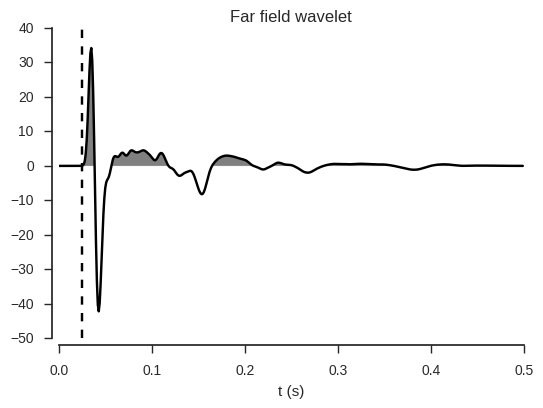

In [4]:
wavelet = np.loadtxt('FarField.dat')
dt = 0.001 # Far Field wavelet time sampling
t = np.arange(wavelet.shape[0]) * dt

# Get the first "non zero" time
t0 = np.argmax(np.abs(wavelet) > 0.03) * dt

plt.fill_between(t, wavelet, where=wavelet > 0, color='gray')
plt.plot(t, wavelet, 'k')
plt.axvline(t0, color='k', ls='--')
plt.xlabel('t (s)')
plt.title('Far field wavelet')
sns.despine(offset=5);

In [5]:
print('Estimated recording delay time: %.3f s [%d samples]' % (t0, t0/dt));

Estimated recording delay time: 0.025 s [25 samples]


## Source wavelet spectrogram using Welch's method

Now I will estimate the spectrogram of the wavelet. This is a little different from Madagascar's sfspectra, since this one uses Welch's method. This gives a smoother periodogram that is more robust to noise, at the expense of some frequency resolution. (see [this stackoverflow anwser](https://stackoverflow.com/questions/29844783/difference-between-magnitude-spectrum-result-available-in-matplotlib-mlab-and-nu) for further details)

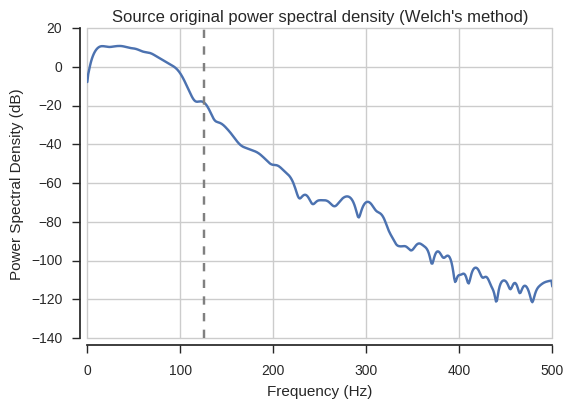

In [6]:
Fs = 1./dt

# This PSD is very sensitive to NFFT (window size) and padding.
Pxx, freqs = plt.psd(wavelet, NFFT=128, detrend='none',
                     noverlap=0, Fs=Fs, pad_to=1024,
                     scale_by_freq=False)

# Ghost notch frequency
plt.axvline(125, color='gray', ls='--')

plt.xlabel('Frequency (Hz)')
plt.title('Source original power spectral density (Welch\'s method)')
sns.despine(offset=5)

On the frequency spectra above the fist notch is probably the ghost notch, since the source towing depth is 6m. This is the result of the interference between the original downgoing wavelet and the wavelet reflected at the sea surface, this interference is most desctrutive at 125 Hz since the delay time is 8 ms (considering water velocity as 1500 m/s and total traveled distance as 12 m).

## Source wavelet spectrogram using FFT and padding

Below I also show the wavelet spectrogram, just to be sure if the window size on Welch's method is not masking the wavelet spectra. Notice, it's the same shape, but noisy.

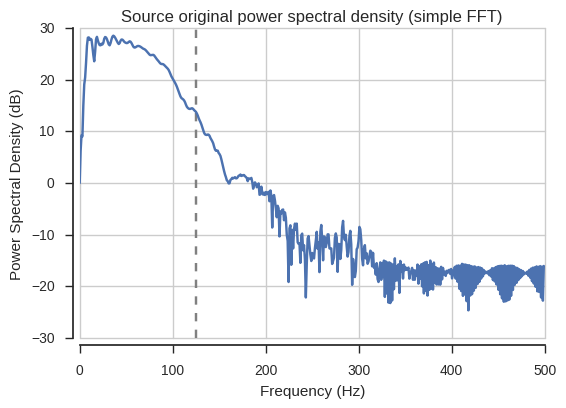

In [7]:
pad_len = 1024
wavelet_pad = np.pad(wavelet, (0, pad_len - len(wavelet)), 'constant')

Pxx = np.abs(np.fft.fft(wavelet_pad))
freqs = np.fft.fftfreq(wavelet_pad.size, dt)

Pxx = Pxx[freqs >= 0]
freqs = freqs[freqs >= 0]

# Ghost notch frequency
plt.axvline(125, color='gray', ls='--')

plt.plot(freqs, 10*np.log10(Pxx/Pxx[0]))
plt.grid()
sns.despine(offset=5)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('Source original power spectral density (simple FFT)');

Let's write the original wavelet to RSF format.

In [8]:
wavelet_original = 'original_source_signature.rsf'

out = sf.Output(wavelet_original)
out.put('n1', wavelet.shape[0])
out.put('d1', dt)
out.put('o1', 0)
out.write(wavelet.astype(np.float32))
out.close()

## Receiver ghost component

Since the cable towing depth is 10 m and the water velocity is 1500 m/s, the delay time for the receiver ghosting is:

In [9]:
v_water = 1.5 #km/s
cable_towing_depth = 0.01 # km 

tr = (2*cable_towing_depth)/v_water # Receiver ghosting delay (s)

print('Delay time for receiver ghost: %f s' % tr)

Delay time for receiver ghost: 0.013333 s


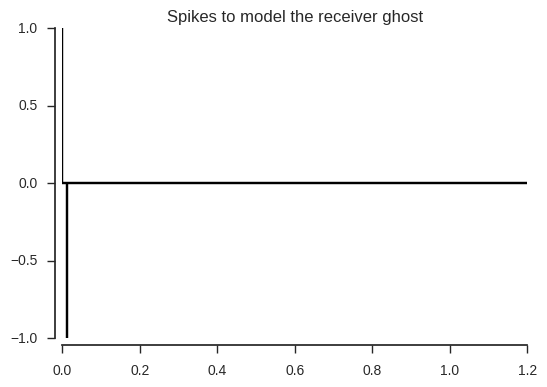

In [10]:
receiver_ghost = np.zeros(wavelet_pad.size)
receiver_ghost[0] = 1
receiver_ghost[np.int(tr/dt)] = -1

t = np.arange(wavelet_pad.size) * dt
plt.vlines(t, [0], receiver_ghost)
plt.axhline(0, color='k')
sns.despine(offset=5)

plt.title('Spikes to model the receiver ghost')

In [11]:
receiver_ghost = np.convolve(wavelet, receiver_ghost, mode='full')

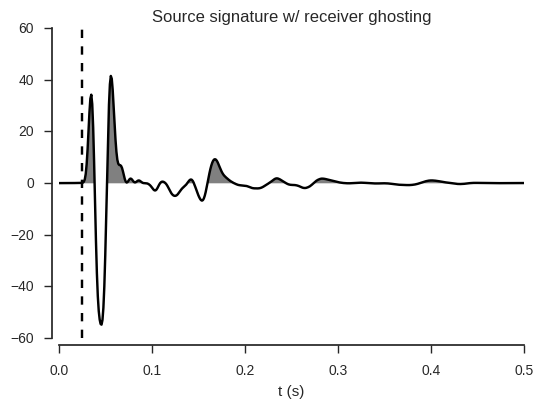

In [12]:
t = np.arange(receiver_ghost.size)*dt
plt.fill_between(t, receiver_ghost, where=receiver_ghost > 0, color='gray')
plt.plot(t, receiver_ghost, 'k')
plt.axvline(t0, color='k', ls='--')
plt.xlabel('t (s)')
plt.title('Source signature w/ receiver ghosting')

plt.xlim(0,0.5)

sns.despine(offset=5)

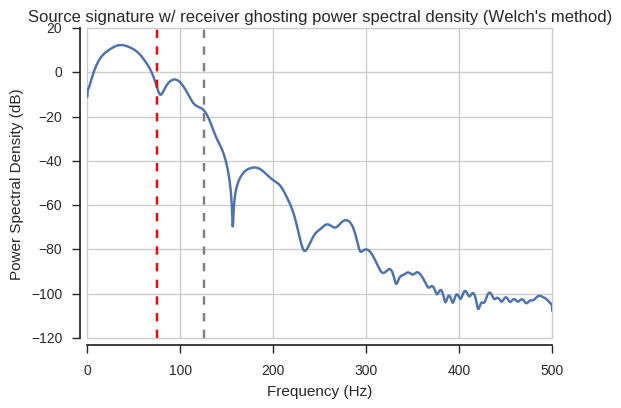

In [13]:
# This PSD is very sensitive to NFFT (window size) and padding.
Pxx, freqs = plt.psd(receiver_ghost, NFFT=128, detrend='none',
                     noverlap=0, Fs=Fs, pad_to=2048,
                     scale_by_freq=False)

# Source ghost notch frequency
plt.axvline(125, color='gray', ls='--')

# Receiver ghost first notch frequency
plt.axvline(1/tr, color='red', ls='--')

plt.xlabel('Frequency (Hz)')
plt.title('Source signature w/ receiver ghosting power spectral density (Welch\'s method)')
sns.despine(offset=5)

Now let's write the wavelet to disk, I'm doing the wavelet filtering, reasampling and the data deghosting using Madagascar programs.

In [14]:
wavelet_receiver_ghosting = 'receiver_ghosting_source_signature.rsf'

out = sf.Output(wavelet_receiver_ghosting)
out.put('n1', receiver_ghost.shape[0])
out.put('d1', dt)
out.put('o1', 0)
out.write(receiver_ghost.astype(np.float32))
out.close()

## Filtering the receiver ghosting

As seen on the spectra above, there are several notches on the spectra for this wavelet. I'll use a low pass filter with cut frequency of 125 Hz and a gentle slope, that way we may remove noise that will polute the deconvolution further ahead. Also, I'll resample this wavelet to 4 ms

To make signtature deconvolution we also need a shorter and smoother version of the wavelet, otherwise the signal gets very polluted with noise.

In [15]:
wavelet_receiver_ghosting_resampled = 'receiver_ghosting_source_signature_resampled.rsf'
f1 = np.int(t0/dt) # Remove the time delay before resampling

!sfwindow f1={f1} < {wavelet_receiver_ghosting} | sfput o1=0 |\
    sfbandpass fhi=65 nphi=8 |\
    sfwindow j1=4 | sfwindow n1=128 |\
    sfpad n1=1500 >  {wavelet_receiver_ghosting_resampled}    

In [16]:
!sfin {wavelet_receiver_ghosting_resampled}

receiver_ghosting_source_signature_resampled.rsf:
    in="/home/rodrigo/Projetos/Viking/DATAPATH/receiver_ghosting_source_signature_resampled.rsf@"
    esize=4 type=float form=native 
    n1=1500        d1=0.004       o1=0          
	1500 elements 6000 bytes


In [17]:
# Create a smooth and shorter wavelet. I'll also go ahead and pad it to the correct lenght

wavelet_receiver_ghosting_smooth = 'receiver_smooth_wavelet.rsf'

!sfsmooth rect1=3 repeat=3 < {wavelet_receiver_ghosting} |\
    sfcut f1=99 | sfbandpass fhi=65 nphi=8 | sfwindow f1={f1} |\
    sfput o1=0 | sfwindow j1=4 | sfwindow n1=128  | sfpad n1=1500 > {wavelet_receiver_ghosting_smooth}

In [18]:
!sfin {wavelet_receiver_ghosting_smooth}

receiver_smooth_wavelet.rsf:
    in="/home/rodrigo/Projetos/Viking/DATAPATH/receiver_smooth_wavelet.rsf@"
    esize=4 type=float form=native 
    n1=1500        d1=0.004       o1=0          
	1500 elements 6000 bytes


## Applying the de-ghosting filter to a sample shot

This can be done using a matched filter, which can be implemented by simple cross-correlation with our minimum phase equivalent resampled wavelet.

The processing steps are:

- Pad the shot and wavelet to the same power of two (2048 samples in this case)
- Use FFT to put both wavelet and shot in frequency domain
- Calculate a apropriate signature deconvolution filter for each source wavelet.
- Multiply in frequency domain
- Do inverse Fourier transform by FFT to put the data back into time domain
- Check for spurious noises and high frequency contamination. If present, check the filtering parameters for each wavelet.
- Profit (?)

In [19]:
data_sample = 'sample_shot.rsf' #shotpoint from well 5
shot_fourier = 'sample_shot_fourier.rsf'

# First let's pad and FFT the shot
!sffft1 < {data_sample} > {shot_fourier}

sffft1: using 2 of 2 threads


In [20]:
!sfin {shot_fourier}

sample_shot_fourier.rsf:
    in="/home/rodrigo/Projetos/Viking/DATAPATH/sample_shot_fourier.rsf@"
    esize=8 type=complex form=native 
    n1=751         d1=0.166667    o1=0          label1="Frequency" unit1="Hz" 
    n2=120         d2=1           o2=0          label2="Trace" 
    n3=1           d3=1           o3=713        
	90120 elements 720960 bytes


Now let's build and apply the first deconvolution operator, perform inverse fourier transform, remove padding and save the shot.

In [21]:
sample_min_phase_deghost = 'sample_min_phase_deghost.rsf'

# FFT the shot and smooth version of the wavelet
!sffft1 < {wavelet_receiver_ghosting_smooth} > d.rsf

sffft1: using 2 of 2 threads


In [22]:
# Create a FFT source wavelet
!sffft1 < {wavelet_receiver_ghosting_resampled} > s.rsf

sffft1: using 2 of 2 threads


In [23]:
# Create a decon operator
decon_operator = 'receiver_deghost_operator.rsf'

!sfmath s=s.rsf d=d.rsf output='(d*conj(s))/(s*conj(s) + 1e-6)' > {decon_operator}

In [24]:
sample_rec_deghost = 'sample_receiver_deghost.rsf'

# Filter a single shot
!sfspray n=120 < {decon_operator} | sfmul {shot_fourier} |\
    sffft1 inv=y | sfbandpass flo=6 fhi=75 nphi=8 > {sample_rec_deghost}

sffft1: using 2 of 2 threads


Now, lets plot them side by side and compare.

In [25]:
data_sample = sf.Input(data_sample)
d1 = data_sample.float('d1')
data_sample = np.array(data_sample)

In [26]:
sample_rec_deghost = np.array(sf.Input(sample_rec_deghost))

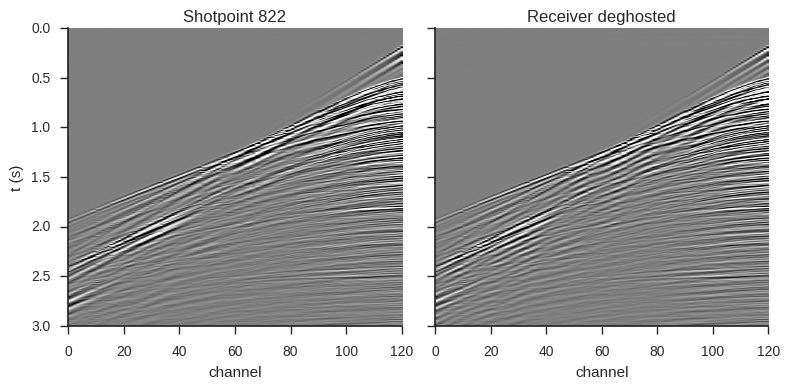

In [27]:
plt.figure(figsize=(8, 4))

titles = ['Shotpoint 822', 'Receiver deghosted']
t = np.arange(data_sample.shape[1]) * d1

for i, data in enumerate([data_sample, sample_rec_deghost]):
    plt.subplot(1,2, i+1)
    perc = np.percentile(data.ravel(), 99)
    extent = [0, data.shape[0], t[-1], t[0]]


    plt.imshow(data.clip(-perc, perc).T, aspect='auto', extent=extent,
              cmap='gray_r')

    if i == 0:
        plt.ylabel('t (s)')
    plt.xlabel('channel')

    plt.title(titles[i])
    plt.ylim(3,0)

    sns.despine()

for ax in plt.gcf().axes:
    try:
        ax.label_outer()
    except:
        pass
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

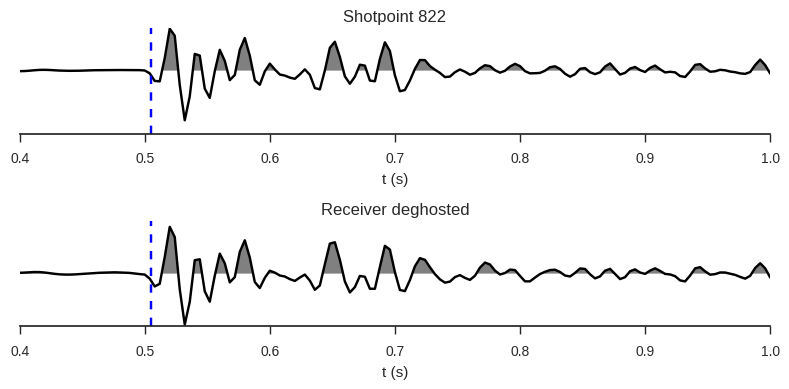

In [28]:
plt.figure(figsize=(8, 4))

for i, data in enumerate([data_sample, sample_rec_deghost]):
    plt.subplot(2,1, i+1)
    trace = data[-1]
    
    plt.fill_between(t, trace, where=trace > 0, color='gray', interpolate=True)
    plt.plot(t, trace, 'k')
    sns.despine(left=True)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.xlabel('t (s)')
    plt.title(titles[i])
    
    # Sea floor reflection time
    t_r = np.sqrt((262.5/2.)**2 + 355.5**2)/1500. * 2

    plt.axvline(t_r, color='b', ls='--')
    plt.xlim(0.4, 1)
    
plt.tight_layout()

In [29]:
data_sample.shape

(120, 1500)

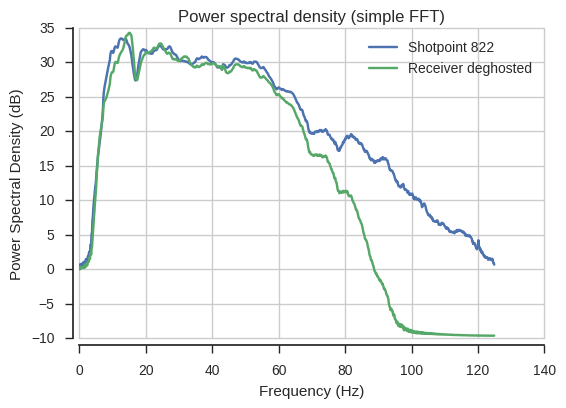

In [30]:
for i, data in enumerate([data_sample, sample_rec_deghost]):
    pad_len = 2048

    shot_pad = np.pad(data,  ((0,0), (0, pad_len - data_sample.shape[1])), 'constant')

    Pxx = np.abs(np.fft.fft(shot_pad, axis=1))
    Pxx = np.mean(Pxx, axis=0)
    freqs = np.fft.fftfreq(shot_pad.shape[1], 0.004)

    Pxx = Pxx[freqs >= 0]
    freqs = freqs[freqs >= 0]

    plt.plot(freqs, 10*np.log10(Pxx/Pxx[0]), label=titles[i])

plt.grid()
sns.despine(offset=5)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('Power spectral density (simple FFT)')

plt.legend(loc='best');